## INTRODUCTION

Rusty Bargain is a used car sales service that is developing an app to attract new customers. Thanks to this app, you can quickly find out the market value of your car. We have access to the history, technical specifications, equipment versions, and prices. We need to create a model that determines the market value.

Rusty Bargain is interested in:

- The quality of the prediction
- The speed of the prediction
- The time required for training
- Use the RECM metric to evaluate the models.

This Dataset come from the ___TrippleTen - Data Scientis Course___.

## DATA DESCRIPTION

car_data.csv
- DateCrawled: the date when the profile was crawled from the database
- VehicleType: the body type of the vehicle
- RegistrationYear: the vehicle's registration year
- Gearbox: the type of gearbox
- Power: power (horsepower)
- Model: the vehicle's model
- Mileage: mileage (measured in kilometers according to the regional specifics of the dataset)
- RegistrationMonth: the vehicle's registration month
- FuelType: the type of fuel
- Brand: the vehicle's brand
- NotRepaired: whether the vehicle has been repaired or not
- DateCreated: the date the profile was created
- NumberOfPictures: the number of pictures of the vehicle
- PostalCode: the postal code of the profile owner (user)
- LastSeen: the date when the user was last active
- Price: In Euros

In [53]:
#pip install --upgrade lightgbm

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler #Escalamiento de valores númericos [] 
from sklearn.preprocessing import OrdinalEncoder #Escalamiento para ml
from sklearn.model_selection import train_test_split

#Pruebas de cordura
from sklearn.metrics import mean_squared_error

#Para problemas de regresión (Valor numérico)
import lightgbm as lgb
from catboost import CatBoostRegressor
import xgboost as xgb

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [55]:
# Getting Data set
rusty_df = pd.read_csv('car_data.csv')

In [56]:
rusty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [57]:
rusty_df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
139921,13/03/2016 09:41,300,small,1994,manual,0,3_reihe,5000,0,NaN,mazda,NaN,13/03/2016 00:00,0,33332,14/03/2016 22:15
325004,15/03/2016 20:51,2700,wagon,2001,manual,101,passat,150000,1,gasoline,volkswagen,no,15/03/2016 00:00,0,94344,17/03/2016 17:45
265743,30/03/2016 21:57,1390,sedan,1998,auto,125,a4,150000,4,petrol,audi,no,30/03/2016 00:00,0,41515,03/04/2016 13:45
61004,24/03/2016 20:59,2000,bus,2004,manual,113,scenic,150000,6,petrol,renault,NaN,24/03/2016 00:00,0,49191,24/03/2016 20:59
66829,04/04/2016 15:47,1500,small,1986,manual,0,NaN,125000,12,petrol,sonstige_autos,no,04/04/2016 00:00,0,85445,06/04/2016 17:18


Remarks

Considering that the following columns have NaN values:

- VehicleType
- Gearbox
- Model
- FuelType
- NotRepaired

The following considerations will be made for data treatment:

- The number of missing elements.
- If there is already a category like 'Other', 'Unknown', etc., to which the missing values can be assigned.
- The impact of creating a category like 'Other', 'Unknown'.

We will also need to convert the column names to lowercase, and the date columns are not necessary, so they will be removed in the following steps, as well as the postal code and number of pictures. According to the project description, these are just informational dates and do not contribute value to the vehicle's price.

## PRE-PROCESSING

In [58]:
print(f"VehicleType =>  {rusty_df['VehicleType'].unique()}")
print(f"Gearbox => {rusty_df['Gearbox'].unique()}")
print(f"FuelType => {rusty_df['FuelType'].unique()}")
print(f"NotRepaired => {rusty_df['NotRepaired'].unique()}")

VehicleType =>  [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Gearbox => ['manual' 'auto' nan]
FuelType => ['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']
NotRepaired => [nan 'yes' 'no']


Once we have obtained the unique values for each column, we can observe the following:

| Columnas     | Contenido   | Solución    |
|--------------|-------------|-------------| 
| VehicleType  | NaN / Other | Add Unknown |
| Gearbox      | NaN         | Add Unknown |
| FuelType     | NaN / Other | Add Unknown |
| NotRepaired  | Nan         | Add Unknown |
| Model        | NaN / Other | Add Unknown |

In the third column, we can see what we will implement for each specific case:

For the case of ___Gearbox and NotRepaired___, we will choose to add the category 'Unknown' since a similar format already exists in the other columns.

In [59]:
# Standarizing the columns names
rusty_df.columns = rusty_df.columns.str.lower()

In [60]:
# Filling NaN values

#  VehicleType
rusty_df['vehicletype'].fillna('Unknown',inplace=True)
# Gearbox
rusty_df['gearbox'].fillna('Unknown',inplace=True)
# FuelType
rusty_df['fueltype'].fillna('Unknown',inplace=True)
# NotRepaired
rusty_df['notrepaired'].fillna('Unknown',inplace=True)
# Model
rusty_df['model'].fillna('Unknown',inplace=True)

C:\Users\JoseC\AppData\Local\Temp\ipykernel_9968\920796946.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rusty_df['vehicletype'].fillna('Unknown',inplace=True)
C:\Users\JoseC\AppData\Local\Temp\ipykernel_9968\920796946.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

In [61]:
rusty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        354369 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            354369 non-null  object
 5   power              354369 non-null  int64 
 6   model              354369 non-null  object
 7   mileage            354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           354369 non-null  object
 10  brand              354369 non-null  object
 11  notrepaired        354369 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

In [62]:
# Dropping columns

columns = ['datecrawled','datecreated','lastseen','postalcode','numberofpictures']
rusty_df.drop(columns=columns, inplace= True)

In [63]:
# Removing duplicates
rusty_df = rusty_df.drop_duplicates().reset_index(drop=True)

In [64]:
rusty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326826 entries, 0 to 326825
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              326826 non-null  int64 
 1   vehicletype        326826 non-null  object
 2   registrationyear   326826 non-null  int64 
 3   gearbox            326826 non-null  object
 4   power              326826 non-null  int64 
 5   model              326826 non-null  object
 6   mileage            326826 non-null  int64 
 7   registrationmonth  326826 non-null  int64 
 8   fueltype           326826 non-null  object
 9   brand              326826 non-null  object
 10  notrepaired        326826 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.4+ MB


In [65]:
# Getting Statistical Description
rusty_df.describe()

,price,registrationyear,power,mileage,registrationmonth
count,326826.000000,326826.000000,326826.000000,326826.000000,326826.000000
mean,4403.747330,2004.230985,110.244705,128144.073605,5.696239
std,4518.209808,91.120018,195.886373,37947.663920,3.724122
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1000.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6350.000000,2008.000000,141.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


<Axes: >

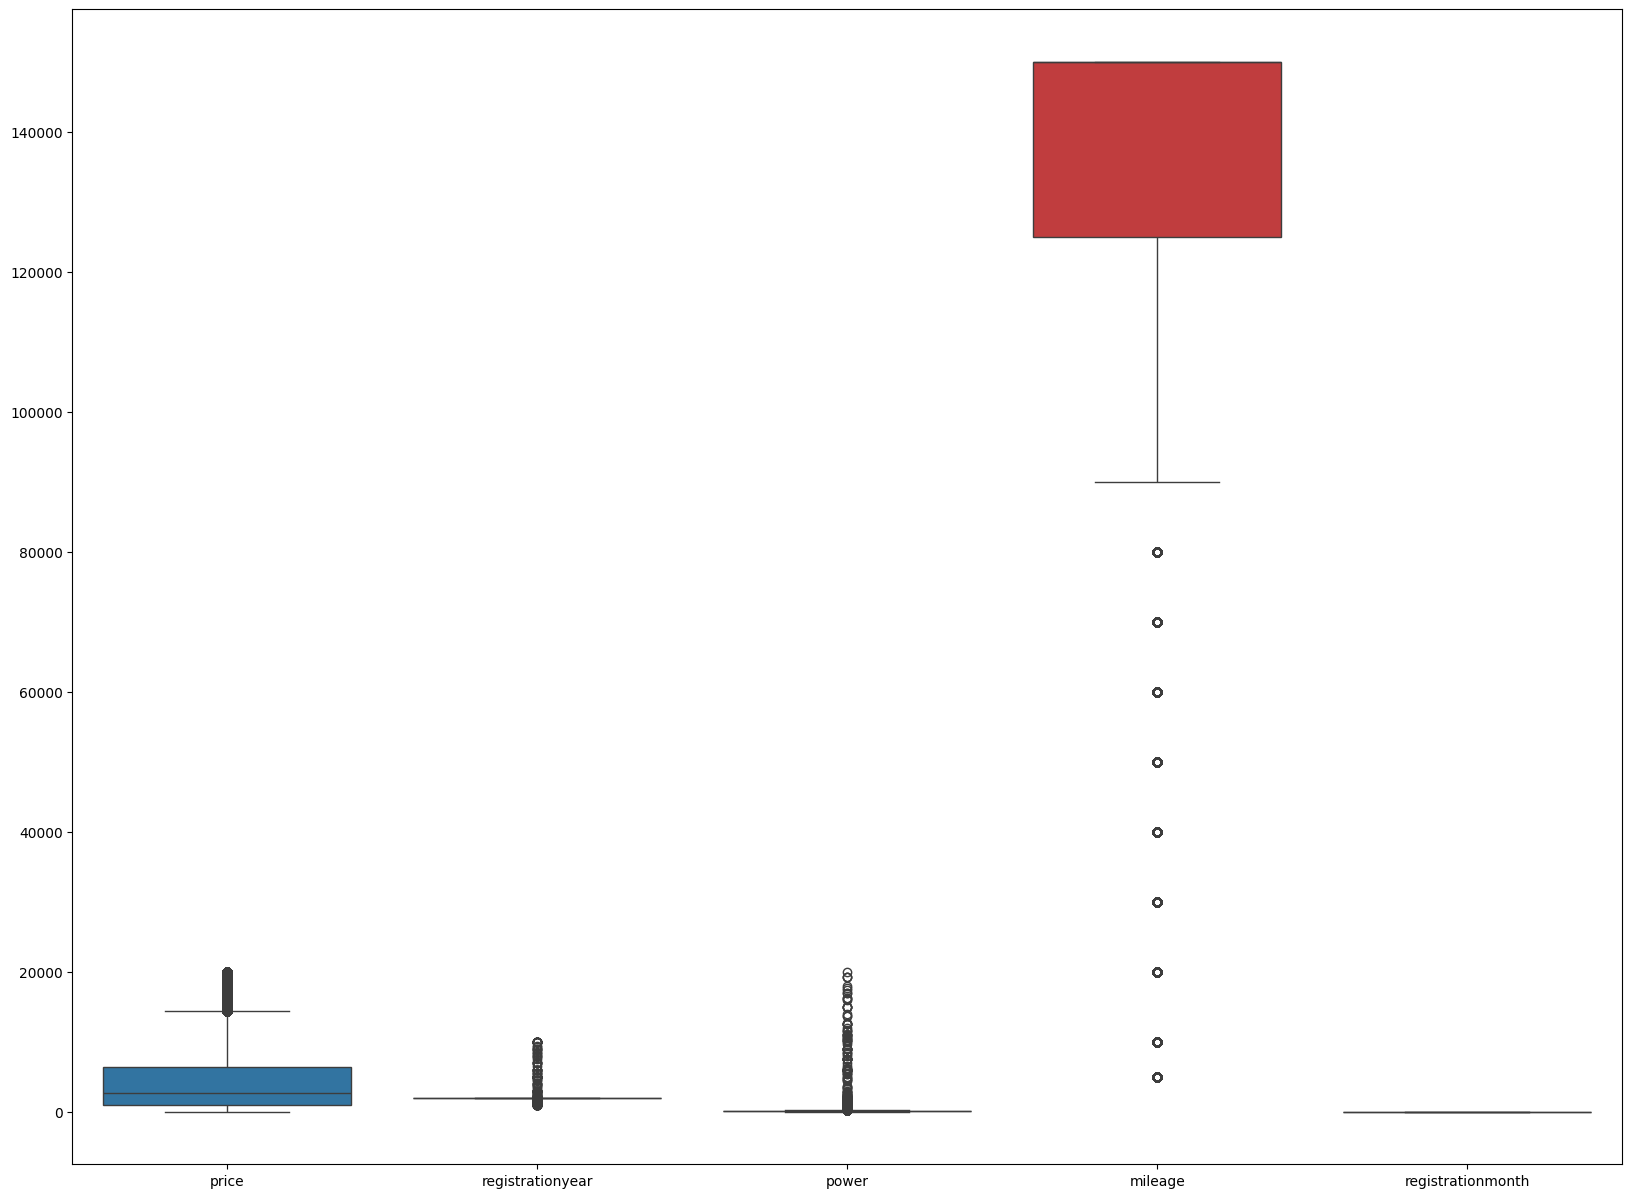

In [66]:
# Creating a boxplot

plt.figure(figsize=(20, 15))
numeric_vals = rusty_df[['price','registrationyear','power','mileage','registrationmonth']]
sns.boxplot(data=numeric_vals)

Remarks

We can notice that ___registrationyear___ has a maximum value of ___9999___ and a minimum value of ___1000___, which doesn't make sense if it represents the year the vehicle was registered. Therefore, we will need to investigate what is happening and remove any values that are inconsistent.

For the case of ___power___, we might be deteling the values with 0 as well.

In [67]:
# Extract unique values to determine the range to be used

unique_vals = sorted(rusty_df['registrationyear'].unique())
print(unique_vals)

[1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500, 1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000, 3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200, 8455, 8500, 8888, 9000, 9229, 9450, 9996, 9999]


In [68]:
# Verify from which year there is a reasonable amount of records.

rusty_df[(rusty_df['registrationyear']>= 1950) & (rusty_df['registrationyear'] <= 2024)].groupby('registrationyear')['price'].count()

registrationyear
1950      18
1951      12
1952       9
1953      14
1954      11
        ... 
2015    1194
2016    9251
2017    9963
2018    3745
2019      23
Name: price, Length: 70, dtype: int64

In [69]:
# Filter the DataFrame according to the conditions registrationyear >= 1950 & <=2024
rusty_df = rusty_df[(rusty_df['registrationyear'] >= 1960) & (rusty_df['registrationyear'] <= 2024)].reset_index(drop=True)


In [70]:
# Extract the unique values for the 'power' variable
unique_vals2 = sorted(rusty_df['power'].unique())
print(unique_vals2[:40])


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


In [71]:
# Remove all records where the value of 'power' is 0
rusty_df = rusty_df[rusty_df['power'] > 0].reset_index(drop=True)

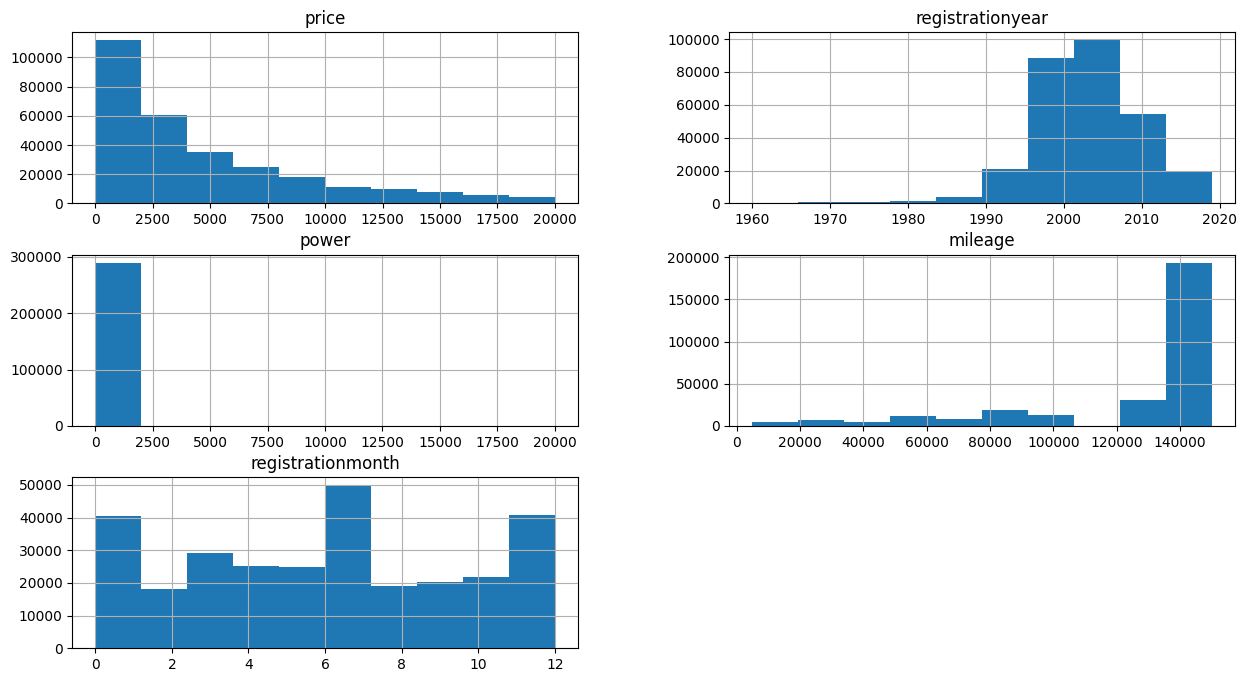

In [72]:
# Create a histogram to visualize the values
rusty_df.hist(figsize=(15, 8))  # Figure size (width, height)
plt.show()

Remarks

We can notice the following:

- ___Price:___ It has a positive skew.
- ___RegistrationYear:___ It has a negative skew.
- ___Power:___ Due to the inability to determine if its values are real or not, it appears as a single peak.
- ___Mileage:___ It has a very irregular negative skew.
- ___RegistrationMonth:___ It has multiple peaks, making it also very irregular.

In [73]:
def standard_75_25(df):
    
    # Separate features from the target
    f = df.drop(['price'], axis=1)
    t = df['price']

    # Split the dataset into a 75/25 proportion
    f_train, f_valid, t_train, t_valid = train_test_split(f, t, test_size=0.25, random_state=1996)

    # Create explicit copies of f_train and f_valid
    f_train = f_train.copy()
    f_valid = f_valid.copy()

    # Standardize the numerical values using StandardScaler
    # Define the numerical columns
    df_columns2 = ['registrationyear', 'power', 'mileage', 'registrationmonth']

    # Perform the standardization
    # Use .loc[:,] to specify that only certain columns will be standardized across all rows
    scaler = StandardScaler()
    f_train.loc[:, df_columns2] = scaler.fit_transform(f_train.loc[:, df_columns2])
    f_valid.loc[:, df_columns2] = scaler.transform(f_valid.loc[:, df_columns2])
    
    return f_train, f_valid, t_train, t_valid

# Determine the categorical columns
df_columns = ['vehicletype', 'gearbox','model', 'fueltype', 'brand', 'notrepaired'] # Removed the 'model' variable

# Duplicate the original df and determine the new categorical data
df_columns_encoded = ['vehicletype_encoded', 'gearbox_encoded','model_encoded', 'fueltype_encoded', 'brand_encoded', 'notrepaired_encoded'] # Removed the 'model' variable
df_ordinal_encoder = rusty_df.copy()



### Standardization for the Linear Regression Model - With One-Hot Encoding (OHE)

In [74]:
# Standardize the nominal categorical values with One-Hot Encoding

# Perform the standardization
df_one_hot = pd.get_dummies(rusty_df, columns=df_columns, drop_first=True)

# Proceed to obtain the validation and training sets
f_train1, f_valid1, t_train1, t_valid1 = standard_75_25(df_one_hot)

C:\Users\JoseC\AppData\Local\Temp\ipykernel_9968\660504428.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.25288638 1.40480903 1.11682837 ... 0.68485737 0.68485737 0.25288638]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  f_train.loc[:, df_columns2] = scaler.fit_transform(f_train.loc[:, df_columns2])
C:\Users\JoseC\AppData\Local\Temp\ipykernel_9968\660504428.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.30557186 -0.09361377  0.07498926 ... -0.01172087 -0.07434485
  0.05572034]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  f_train.loc[:, df_columns2] = scaler.fit_transform(f_train.loc[:, df_columns2])
C:\Users\JoseC\AppData\Local\Temp\ipykernel_9968\660504428.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will

### Standardization for Other Models - With Ordinal Encoder

In [75]:
# Create an instance of OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Add the new columns to the DataFrame
df_ordinal_encoder[df_columns_encoded] = ordinal_encoder.fit_transform(df_ordinal_encoder[df_columns])

# Drop the original columns
df_ordinal_encoder = df_ordinal_encoder.drop(df_columns, axis=1)

# Proceed to obtain the validation and training sets
f_train, f_valid, t_train, t_valid = standard_75_25(df_ordinal_encoder)




C:\Users\JoseC\AppData\Local\Temp\ipykernel_9968\660504428.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.25288638 1.40480903 1.11682837 ... 0.68485737 0.68485737 0.25288638]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  f_train.loc[:, df_columns2] = scaler.fit_transform(f_train.loc[:, df_columns2])
C:\Users\JoseC\AppData\Local\Temp\ipykernel_9968\660504428.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.30557186 -0.09361377  0.07498926 ... -0.01172087 -0.07434485
  0.05572034]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  f_train.loc[:, df_columns2] = scaler.fit_transform(f_train.loc[:, df_columns2])
C:\Users\JoseC\AppData\Local\Temp\ipykernel_9968\660504428.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will

## Training Models

### Decision Tree Regressor

In [76]:
# Search for the best possible combination

# Initialize parameters
best_result = 10000
best_depth = 0

for depth in range(1, 30):  # select the range of the hyperparameter
    tree_model = DecisionTreeRegressor(random_state=1996, max_depth=depth)
    tree_model.fit(f_train, t_train)  # train the model on the training set
    p_valid = tree_model.predict(f_valid)  # get predictions from the model on the validation set
    rmse = mean_squared_error(t_valid, p_valid) ** 0.5  # calculate the RMSE on the validation set
    if rmse < best_result:
        best_result = rmse
        best_depth = depth

print(f"RMSE of the best model on the validation set (max_depth = {best_depth}): {best_result}")


RMSE of the best model on the validation set (max_depth = 12): 2061.4948027381106


In [77]:
# Start the timer with the best RMSE
start_time = time.time()

# Create model 
tree_model = DecisionTreeRegressor(random_state=1996, max_depth=12)

# Train model
tree_model.fit(f_train, t_train)  # train the model on the training set
p_valid = tree_model.predict(f_valid)  # get predictions from the model on the validation set

# Calculate RMSE as the evaluation metric
tree_rmse = mean_squared_error(t_valid, p_valid) ** 0.5  # calculate RMSE on the validation set

# Calculate execution time
end_time = time.time()
tree_execution_time = end_time - start_time
print(f"Execution time: {tree_execution_time:.2f} seconds")

print(f"RMSE: {tree_rmse:.4f}")

Execution time: 0.53 seconds
RMSE: 2061.4948


### Random Forest Regressor

In [78]:
# Search for the best possible combination

# Initialize parameters
best_error = 10000  # set the starting RMSE
best_est = 0
best_depth = 0

# Loop through various hyperparameters with increments of 5
for depth in range(1, 40, 5):
    forest_model = RandomForestRegressor(random_state=1996, n_estimators=20, max_depth=depth)
    forest_model.fit(f_train, t_train)  # train the model on the training set
    p_valid = forest_model.predict(f_valid)
    rmse = mean_squared_error(t_valid, p_valid) ** 0.5  # calculate the RMSE on the validation set
    
    # Store the best error, estimator, and depth
    if rmse < best_error:  # save the model configuration if it achieves the lowest error
        best_error = rmse
        best_depth = depth

print(f"The best RMSE: {best_error} with a depth of {best_depth}")

The best RMSE: 1793.8902380320449 with a depth of 21


In [79]:
# Start the timer with the best RMSE
start_time = time.time()

# Create model
forest_model = RandomForestRegressor(random_state=1996, n_estimators=25, max_depth=21)

# Train model
forest_model.fit(f_train, t_train)  # train the model on the training set
p_valid = forest_model.predict(f_valid)

# Calculate RMSE as the evaluation metric
forest_rmse = mean_squared_error(t_valid, p_valid) ** 0.5  # calculate RMSE on the validation set

# Calculate execution time
end_time = time.time()
forest_execution_time = end_time - start_time
print(f"Execution time: {forest_execution_time:.2f} seconds")

print(f"RMSE: {forest_rmse:.4f}")


Execution time: 17.77 seconds
RMSE: 1786.6863


### Logistic Regression

In [80]:
# Start the timer with the best RMSE
start_time = time.time()

# Create model
log_model = LinearRegression()

# Train model
log_model.fit(f_train1, t_train1)
p_valid1 = log_model.predict(f_valid1)

# Calculate RMSE as the evaluation metric
log_rmse = mean_squared_error(t_valid1, p_valid1) ** 0.5

# Calculate execution time
end_time = time.time()
log_execution_time = end_time - start_time
print(f"Execution time: {log_execution_time:.2f} seconds")

print(f"RMSE: {log_rmse:.4f}")


Execution time: 7.35 seconds
RMSE: 2822.1237


### LGBM

In [81]:
# Start the timer with the best RMSE
start_time = time.time()

# Convert the data to the specific format for LightGBM
train_data = lgb.Dataset(f_train, label=t_train)
test_data = lgb.Dataset(f_valid, label=t_valid, reference=train_data)

# Define the model parameters
params = {
    'objective': 'regression',   # Regression problem
    'metric': 'mse',             # Evaluation metric: Mean Squared Error
    'boosting_type': 'gbdt',     # Boosting type: Gradient Boosting Decision Tree
    'num_leaves': 30,            # Maximum number of leaves per tree
    'learning_rate': 0.1,        # Model learning rate
    'feature_fraction': 0.8,     # Fraction of features to consider per tree
    'bagging_fraction': 0.8,     # Fraction of data to use per tree
    'bagging_freq': 1,           # Frequency of bagging
    'verbose': 1                 # Show information during training (0 for nothing, 1 to see training progress, and >1 to see all messages)
}

# Train the model
num_round = 350
lgb_model = lgb.train(params, train_data, num_round, valid_sets=[test_data])
p_valid = lgb_model.predict(f_valid, num_iteration=lgb_model.best_iteration)

# Calculate RMSE as the evaluation metric
lgb_rmse = mean_squared_error(t_valid, p_valid) ** 0.5

# Calculate execution time
end_time = time.time()
lgb_execution_time = end_time - start_time
print(f"Execution time: {lgb_execution_time:.2f} seconds")

print(f"RMSE: {lgb_rmse:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 654
[LightGBM] [Info] Number of data points in the train set: 217190, number of used features: 10
[LightGBM] [Info] Start training from score 4681.449878
Execution time: 2.21 seconds
RMSE: 1738.3078


### CatBoost Regressor

In [82]:
# Start the timer with the best RMSE
start_time = time.time()

# Define the model parameters
cat_model = CatBoostRegressor(iterations=700,
                              learning_rate=0.1,
                              depth=8,
                              loss_function='RMSE',
                              random_state=1196)

# Train the model
cat_model.fit(f_train, t_train, verbose=100)
p_valid = cat_model.predict(f_valid)

# Evaluate the model
cat_rmse = mean_squared_error(t_valid, p_valid) ** 0.5

# Calculate execution time
end_time = time.time()
cat_execution_time = end_time - start_time
print(f"Execution time: {cat_execution_time:.2f} seconds")

print(f"RMSE: {cat_rmse:.4f}")


0:	learn: 4277.8589418	total: 30.6ms	remaining: 21.4s
100:	learn: 1811.7220298	total: 2.27s	remaining: 13.5s
200:	learn: 1718.8011142	total: 4.46s	remaining: 11.1s
300:	learn: 1672.2381160	total: 6.72s	remaining: 8.9s
400:	learn: 1639.4374343	total: 8.92s	remaining: 6.65s
500:	learn: 1611.1587657	total: 11.3s	remaining: 4.5s
600:	learn: 1589.0299922	total: 14.1s	remaining: 2.33s
699:	learn: 1569.2259145	total: 16.3s	remaining: 0us
Execution time: 16.69 seconds
RMSE: 1715.9567


### XBG Regressor

In [83]:
# Start the timer with the best RMSE
start_time = time.time()

# Define the model parameters
params = {
    'objective': 'reg:squarederror',  # Loss function for regression
    'max_depth': 10,                  # Maximum depth of the tree
    'learning_rate': 0.1,             # Learning rate
    'n_estimators': 120               # Number of trees (estimators)
}

# Create the model
xgb_model = xgb.XGBRegressor(**params)
xgb_model.fit(f_train, t_train)
p_valid = xgb_model.predict(f_valid)

# Evaluate the model
xgb_rmse = mean_squared_error(t_valid, p_valid) ** 0.5

# Calculate the execution time
end_time = time.time()
xgb_execution_time = end_time - start_time
print(f"Execution time: {xgb_execution_time:.2f} seconds")

print(f"RMSE: {xgb_rmse:.4f}")

Execution time: 2.03 seconds
RMSE: 1706.7336


### COMPARING MODELS

In [84]:
# Create a DataFrame with the results
ml_names = ['DecisionTree', 'RandomForest', 'LinearRegression', 'LGBM', 'CATBOOST', 'XGB']
rmse_df = pd.DataFrame(
    {
        'Execution Time (sec)':[tree_execution_time, forest_execution_time, log_execution_time, lgb_execution_time, cat_execution_time, xgb_execution_time],
        'RMSE':[tree_rmse, forest_rmse, log_rmse, lgb_rmse, cat_rmse, xgb_rmse],
    },
    index= ml_names
)


In [85]:
# General table
rmse_df

,Execution Time (sec),RMSE
DecisionTree,0.530017,2061.494803
RandomForest,17.766614,1786.686294
LinearRegression,7.345530,2822.123714
LGBM,2.206648,1738.307768
CATBOOST,16.686579,1715.956686
XGB,2.028952,1706.733649


In [86]:
# Top 3 RMSE
rmse_df.sort_values(by='RMSE').head(3)

,Execution Time (sec),RMSE
XGB,2.028952,1706.733649
CATBOOST,16.686579,1715.956686
LGBM,2.206648,1738.307768


In [87]:
# Top 3 Best times execution
rmse_df.sort_values(by='Execution Time (sec)').head(3)

,Execution Time (sec),RMSE
DecisionTree,0.530017,2061.494803
XGB,2.028952,1706.733649
LGBM,2.206648,1738.307768


## FINAL CONCLUTION

- We can observe that XGB achieved the best RMSE among the 6 models with an average of approximately 2.61 seconds, followed by CATBOOST. However, LGBM achieved a very close value in a shorter time.

Therefore, in this case, we could consider that the best option for determining the value of a vehicle could be achieved using the XGB method, as its execution time is the second lowest but it has the best RMSE.